In [1]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import pickle
import time
from tqdm import tqdm
import torch
import torch.nn.functional as f
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score,f1_score

In [2]:
##load data index
train_index_path = r'C:\Users\东\Desktop\train1.csv'
test_index_path = r'C:\Users\东\Desktop\test1.csv'
train_index=pd.read_csv(train_index_path)['0'].values.astype(np.int)
test_index=pd.read_csv(test_index_path)['0'].values.astype(np.int)

In [3]:
####load spectral data
spectral_data_path=r'C:\Users\东\Desktop\高光谱\WBCs\spectral.csv'
spectral_data=pd.read_csv(spectral_data_path).drop(columns=['No','Class']).values
y_all=pd.read_csv(spectral_data_path)['Class'].values
x_spectral_train=spectral_data[train_index]
x_spectral_test=spectral_data[test_index]
y_train=y_all[train_index]
y_test=y_all[test_index]

In [4]:
def build_convolutional_block(input_channels: int, output_channels: int) -> torch.nn.Sequential:
    """
    Create convolutional block for the network.

    :param input_channels: Number of input feature maps.
    :param output_channels: Number of designed output feature maps.
    :return: Sequential module.
    """
    return torch.nn.Sequential(
        torch.nn.Conv1d(in_channels=input_channels, out_channels=output_channels, kernel_size=5, padding=2),
        torch.nn.ReLU(),
        torch.nn.BatchNorm1d(output_channels),
        torch.nn.MaxPool1d(2)
    )


def build_classifier_block(input_size: int, number_of_classes: int) -> torch.nn.Sequential:
    """
    Build classifier block designed for obtaining the prediction.

    :param input_size: Input number of features.
    :param number_of_classes: Number of classes.
    :return: Sequential module.
    """
    return torch.nn.Sequential(
        torch.nn.Linear(input_size, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, number_of_classes)
    )


def build_softmax_module(input_channels: int) -> torch.nn.Sequential:
    """
    Build softmax module for attention mechanism.

    :param input_channels: Number of input feature maps.
    :return: Sequential module.
    """
    return torch.nn.Sequential(
        torch.nn.Conv1d(in_channels=input_channels, out_channels=1, kernel_size=1),
        torch.nn.ReLU(),
        torch.nn.Softmax(dim=2)
    )


def build_classifier_confidence(input_channels: int) -> torch.nn.Sequential:
    """
    Create sequential module for classifier confidence score.

    :param input_channels: Number of input activation maps.
    :return: Sequential module.
    """
    return torch.nn.Sequential(
        torch.nn.Linear(input_channels, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, 1),
        torch.nn.Tanh()
    )


class AttentionBlock(torch.nn.Module):
    def __init__(self, input_channels: int, input_dimension: int, num_classes: int):
        """
        Attention module constructor.

        :param input_channels: Number of input activation maps.
        :param input_dimension: Size of input spectral dimensionality.
        :param num_classes: Number of classes.
        """
        super(AttentionBlock, self).__init__()
        self._softmax_block_1 = build_softmax_module(input_channels)
        self._confidence_net = torch.nn.Sequential(
            torch.nn.Linear(input_dimension, 1),
            torch.nn.Tanh()
        )
        self._attention_net = torch.nn.Sequential(
            torch.nn.Linear(input_dimension, num_classes)
        )
        self._attention_heatmaps = [[] for _ in range(num_classes)]

    def forward(self, z: torch.Tensor, y: torch.Tensor, infer: bool) -> torch.Tensor:
        """
        Feed forward method for attention module.

        :param z: Input tensor.
        :param y: Labels.
        :param infer: Boolean variable indicating whether to save attention heatmap which is later used in the
                      band selection process.
        :return: Weighted attention module hypothesis.
        """
        heatmap = self._softmax_block_1(z)
        if infer:
            for i, class_ in enumerate(y):
                self._attention_heatmaps[torch.argmax(class_)].append(heatmap[i])
        cross_product = torch.einsum("ijk,ilk->ijlk", (heatmap.clone(), z.clone())) \
            .reshape(heatmap.shape[0], -1, heatmap.shape[2])
        cross_product = f.avg_pool1d(cross_product.permute(0, 2, 1), cross_product.shape[1])
        cross_product = cross_product.squeeze()
        return self._attention_net(cross_product) * self._confidence_net(cross_product)

    def get_heatmaps(self, input_size: int) -> np.ndarray:
        """
        Return heatmaps given initial spectral size.
        The heatmaps are interpolated to specified spectral size.

        :param input_size: Designed spectral size.
        :return: Array containing heatmaps collected by the attention module.
        """
#         print(range(self._attention_heatmaps[0].__len__()))
        for i in range(self._attention_heatmaps.__len__()):
            for j in range(self._attention_heatmaps[i].__len__()):
                self._attention_heatmaps[i][j] = resize(self._attention_heatmaps[i][j].cpu().detach().numpy(), (1, input_size))
        for i in range(self._attention_heatmaps.__len__()):
            self._attention_heatmaps[i] = np.mean(self._attention_heatmaps[i], axis=0)
        return np.asarray(self._attention_heatmaps)

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class RestNetBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(RestNetBasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        output = self.conv1(x)
        output = F.relu(self.bn1(output))
        output = self.conv2(output)
        output = self.bn2(output)
        return F.relu(x + output)


class RestNetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(RestNetDownBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride[0], padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=stride[1], padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.extra = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride[0], padding=0),
            nn.BatchNorm1d(out_channels)
        )

    def forward(self, x):
        extra_x = self.extra(x)
        output = self.conv1(x)
        out = F.relu(self.bn1(output))

        out = self.conv2(out)
        out = self.bn2(out)
        return F.relu(extra_x + out)


class model4(nn.Module):
    def __init__(self, num_of_classes: int, input_dimension: int, uses_attention: bool = True):
        super(model4, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(RestNetBasicBlock(64, 64, 1),
                                    RestNetBasicBlock(64, 64, 1))

        self.layer2 = nn.Sequential(RestNetDownBlock(64, 128, [2, 1]),
                                    RestNetBasicBlock(128, 128, 1))

        self.layer3 = nn.Sequential(RestNetDownBlock(128, 256, [2, 1]),
                                    RestNetBasicBlock(256, 256, 1))

        self.layer4 = nn.Sequential(RestNetDownBlock(256, 512, [2, 1]),
                                    RestNetBasicBlock(512, 512, 1))

        self.avgpool = nn.AdaptiveAvgPool1d(output_size=(1))

        self.fc = nn.Linear(512, num_of_classes)
        if uses_attention:
            print("Model with 2 attention modules.")
#             self._attention_block_1 = AttentionBlock(64, int(input_dimension / 2), num_of_classes)
            self._attention_block_2 = AttentionBlock(64, int(input_dimension / 2), num_of_classes)
            self._attention_block_3 = AttentionBlock(128, int(input_dimension / 4), num_of_classes)
            self._attention_block_4 = AttentionBlock(256, int(input_dimension / 8), num_of_classes)

            self._classifier_confidence = build_classifier_confidence(512)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.00001)
        self.loss = torch.nn.BCELoss()
        self.uses_attention = uses_attention

    def forward(self, x, y, infer):
        global  second_module_prediction, \
            third_module_prediction, fourth_module_prediction

        z = self.conv1(x)
#         if self.uses_attention:
#             first_module_prediction = self._attention_block_1(z, y, infer)
        z = self.layer1(z)
        if self.uses_attention:
            second_module_prediction = self._attention_block_2(z, y, infer)
        z = self.layer2(z)
        if self.uses_attention:
            third_module_prediction = self._attention_block_3(z, y, infer)
        z = self.layer3(z)
        if self.uses_attention:
            fourth_module_prediction = self._attention_block_4(z, y, infer)
        z = self.layer4(z)
        z = self.avgpool(z)
        z = z.reshape(x.shape[0], -1)

        prediction = self.fc(z)
        # print(prediction.shape)  #(10,5)
        # a = z.view(z.shape[0], -1)
        # b= self._classifier_confidence(z.view(z.shape[0], -1))
        # print(b.shape) #(10,1)
        # print(a.shape) #(10,512)
        if self.uses_attention:
            # print((self._classifier_confidence(z.view(z.shape[0], -1))).shape)
            prediction *= self._classifier_confidence(z.view(z.shape[0], -1))
        if self.uses_attention:
            return f.softmax(prediction + second_module_prediction + \
                             third_module_prediction + fourth_module_prediction, dim=1)
        return f.softmax(prediction, dim=1)

    def get_heatmaps(self, input_size: int) -> np.ndarray:
        """
       Return averaged heatmaps for model with four attention modules.

       :param input_size: Designed spectral size.
       :return: Array containing averaged scores for interpolated heatmaps.
       """
        return np.mean([self._attention_block_2.get_heatmaps(input_size).squeeze(),
                        self._attention_block_3.get_heatmaps(input_size).squeeze(),
                        self._attention_block_4.get_heatmaps(input_size).squeeze()], axis=0).squeeze()

In [6]:
model=model4(5,360)
model

Model with 2 attention modules.


model4(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): RestNetBasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): RestNetBasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [7]:
epochs=50
batch_size=50
output_dir=r'E:\data\1D_attentation_1'
patience =5
def train_network(x_train: np.ndarray, y_train: np.ndarray, model,):
    training_history = []
    loss_history = []
    training_time = []

    for current_epoch in range(epochs):
        torch.enable_grad()
        model.train()
        for param in model.parameters():
            param.requires_grad = True

        print("Epoch {}:".format(current_epoch))
        print("\tTraining phase:")

        training_accuracies = []
        losses = []
        begin = time.time()

        x_train_list = [x_train[i:i + batch_size] for i in range(0, len(x_train), batch_size)]
        y_train_list = [y_train[i:i + batch_size] for i in range(0, len(y_train), batch_size)]

        for x, y in tqdm(zip(x_train_list, y_train_list), total=len(x_train_list)):
            x = torch.from_numpy(x.astype("float32")).unsqueeze(1).type(torch.cuda.FloatTensor)
            y = torch.from_numpy(y.astype("float32")).type(torch.cuda.LongTensor)
            y = (torch.nn.functional.one_hot(y, num_classes=5)).type(torch.cuda.FloatTensor)
            model.zero_grad()
            model.optimizer.zero_grad()
            out = model(x, y, infer=True)
            loss = model.loss(out, y)
            losses.append(loss.clone().detach().cpu().numpy())
            accuracy = (torch.argmax(out, dim=1) == torch.argmax(y, dim=1)).sum().type(torch.cuda.DoubleTensor) / \
                    y.shape[0]
            training_accuracies.append(accuracy.cpu().numpy())
            loss.backward()
            model.optimizer.step()
        training_time.append(time.time() - begin)
        loss_history.append(np.mean(losses))
        training_history.append(np.mean(training_accuracies))

        print("\tLoss: {0} ".format(loss_history[-1]))
        print("\tTraining accuracy: {0} ".format(training_history[-1]))

        # 创建输出文件夹
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        pickle.dump(training_history,
                    open(os.path.join(output_dir, '1d' + "_training_history.pkl"), "wb"))

        pickle.dump(loss_history, open(os.path.join(output_dir, '1d' + "_loss_history.pkl"), "wb"))
        pickle.dump(training_time,
                    open(os.path.join(output_dir, '1d' + "_time_training.pkl"), "wb"))

        if current_epoch ==  0 or (training_history[-1] > max(training_history[:-1])):
            print("\tSaving model...")
            torch.save(model, os.path.join(output_dir, '1d' + "_model.pt"))
        if current_epoch > patience:
            if max(training_history[:-patience]) > max(training_history[-patience:]):
                print("\tBail...")
                break

In [8]:
def infer_network(x_test: np.ndarray, y_test: np.ndarray, input_size: int):
    """
    Conduct inference on the trained model.

    :param x_test: Samples for testing.
    :param y_test: Labels for testing.
    :param args: Parsed arguments.
    :param input_size: Size of the initial band spectrum.
    :return: None.
    """
    model = torch.load(os.path.join(output_dir, '1d' + "_model.pt"))

    testing_accuracies = []
    pres = []
    labels = []

    torch.no_grad()
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

    print("\tTesting:")

    begin = time.time()
    x_test_list = [x_test[i:i + batch_size] for i in range(0, len(x_test), batch_size)]
    y_test_list = [y_test[i:i + batch_size] for i in range(0, len(y_test), batch_size)]

    for x, y in tqdm(zip(x_test_list, y_test_list), total=len(x_test_list)):
        x = torch.from_numpy(x.astype("float32")).unsqueeze(1).type(torch.cuda.FloatTensor)
        y = torch.from_numpy(y.astype("int32")).type(torch.cuda.LongTensor)
        y = (torch.nn.functional.one_hot(y, num_classes=5)).type(torch.cuda.FloatTensor)
        accuracy = (torch.argmax(model(x, y, infer=True), dim=1) == torch.argmax(y, dim=1)).sum().type(
            torch.cuda.DoubleTensor) / y.shape[0]
        testing_accuracies.append(accuracy.cpu().numpy())
        pred1 = torch.argmax(model(x, y, infer=True), dim=1)
        pres = np.append(pres,pred1.cpu().numpy())
        y_t = torch.argmax(y, dim=1)
        labels=np.append(labels,y_t.cpu().numpy())

    testing_time = time.time() - begin
    testing_accuracy = [np.mean(testing_accuracies)]
    print("\tTesting accuracy: {} ".format(testing_accuracy[0]))
    if model.uses_attention:
        heatmaps_per_class = model.get_heatmaps(input_size=input_size)
        pickle.dump(heatmaps_per_class,
                    open(os.path.join(output_dir, '1d' + "_attention_bands.pkl"), "wb"))

    pickle.dump(testing_accuracy,
                open(os.path.join(output_dir, '1d' + "_testing_accuracy.pkl"), "wb"))
    pickle.dump(testing_time, open(os.path.join(output_dir, '1d' + "_time_testing.pkl"), "wb"))
    cm = confusion_matrix(labels, pres)

    Pre = precision_score(labels,pres,average=None)
    print('Pres:',np.mean(Pre))
    Rec = recall_score(labels,pres,average=None)
    print('Rec:',np.mean(Rec))
    F1 = f1_score(labels,pres,average=None)
    print(np.mean(F1))
    
    Emotion_kinds = 5  # 这个数值是具体的分类数，大家可以自行修改
    labels = ['N', 'E', 'B', 'L', 'M']  # 每种类别的标签
    # 显示数据
    plt.imshow(cm, cmap=plt.cm.Blues)

    # 在图中标注数量/概率信息
    thresh = cm.max() / 2  # 数值颜色阈值，如果数值超过这个，就颜色加深。
    for x in range(Emotion_kinds):
        for y in range(Emotion_kinds):
            # 注意这里的matrix[y, x]不是matrix[x, y]
            info = int(cm[y, x])
            plt.text(x, y, info,
                        verticalalignment='center',
                        horizontalalignment='center',
                        color="white" if info > thresh else "black")

    plt.tight_layout()  # 保证图不重叠
    plt.yticks(range(Emotion_kinds), labels)
    plt.xticks(range(Emotion_kinds), labels, rotation=45)  # X轴字体倾斜45°
    plt.show()
    plt.close()

In [9]:
dataset_path=r'C:\Users\东\Desktop\高光谱\12345_2.csv'
def run(selected_bands: np.ndarray = None):
    device = torch.device("cpu")
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
    os.makedirs(output_dir, exist_ok=True)

    print("Training model for dataset: {}".format(os.path.basename(os.path.normpath(dataset_path))))

#     if selected_bands is not None:
#         selected_bands = np.loadtxt(fname=selected_bands).astype(int)
#     if selected_bands is not None:
#         samples = samples[..., selected_bands]
#         print("Selected bands: {}".format(selected_bands))
#         print("Number of selected bands: {}".format(samples.shape[-1]))

    model.to(device)
#     train_network(x_train=x_spectral_train, y_train=y_train, model=model)
    start = time.time()
    infer_network(x_test=x_spectral_test, y_test=y_test,input_size=x_spectral_train.shape[-1])
    end = time.time()
    print(end-start)

Training model for dataset: 12345_2.csv


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

	Testing:


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.83it/s]


	Testing accuracy: 0.9339999999999999 
Pres: 0.9335664379365805
Rec: 0.9339999999999999
0.9336472896698046


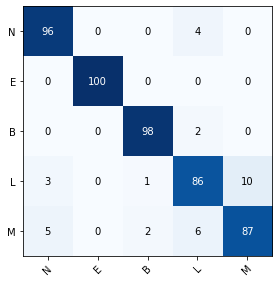

168.83859848976135


In [10]:
run(selected_bands = None)

In [11]:
def plot_heatmaps(heatmaps: np.ndarray, show_fig: bool):
    """
    Plot heatmaps for each class.

    :param heatmaps: Array containing attention scores for all classes.
    :param args: Arguments.
    :param show_fig: Boolean indicating whether to show the selected bands heatmap.
    :return: None.
    """
    fig, axis = plt.subplots()
    heatmap = axis.pcolor(heatmaps)
    axis.set_yticks(list(range(heatmaps.shape[0])), minor=True)
    axis.set_yticklabels(list(range(heatmaps.shape[0])), minor=True)
    plt.colorbar(heatmap)
    fig.set_size_inches(12, 4)
    plt.title("Attention heatmaps scores")
    plt.ylabel("Class")
    plt.xlabel("Band")
    plt.savefig(os.path.join(output_dir, '1d' + "_attention_map.pdf"))
    if show_fig:
        plt.show()

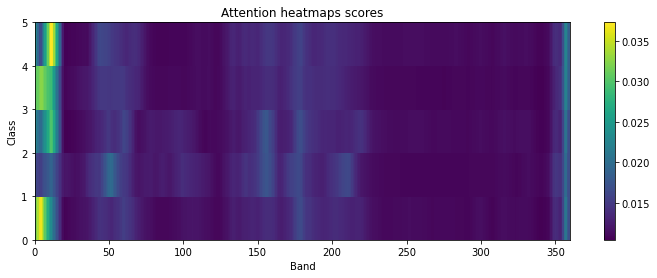

In [12]:
heatmaps = pickle.load(open(os.path.join(output_dir, '1d' + "_attention_bands.pkl"), "rb"))
plot_heatmaps(heatmaps,show_fig=True)